# Advance Lane Finding - PROJECT 2

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Camera Calibration

We need to make sure the camera install in the car is accurate and should provide the same output for the same input in all environments. With the help of OpenCV, we could achieve the desired result.

### Goal
- [X] Read all images from desired folder
- [X] Convert to grayscale
- [X] Find corenrs 
- [X] Calibrate camera

In [2]:
'''
Read all the image from camera_cal
process need glob 
'''
import glob

list_of_images =  glob.glob("camera_cal/*.jpg")
assert len(list_of_images) > 0, "list_of_images should not be empty, " + str(len(list_of_images))

# as per suggession
x_axis_count = 9
y_axis_count = 6 

objectPoints = [] # vector of vectors of calibration patten points
imagePoints = [] # vector of vectors of projections of calibration pattern points

'''
object points,
[ 0, 0, 0 ] to | 8, 5, 0|
'''
objectPointsPattern = np.zeros((x_axis_count * y_axis_count, 3), np.float32)
objectPointsPattern[:,:2] = np.mgrid[0:x_axis_count, 0:y_axis_count].T.reshape(-1, 2)

'''
Iterate and search for corners
'''
image = None # image
for idx, fname in enumerate(list_of_images):
    image = cv2.imread(fname) # read image 
    
    '''
    Note:
        cv2.COLOR_RGB2GRAY for matplotlib.imread
        cv2.COLOR_BGR2GRAY for cv2.imread
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    '''
    Find the corners
    '''
    patternSize = (x_axis_count, y_axis_count)
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
    
    '''
    Store result only if pattern found
    '''
    if ret:
        objectPoints.append(objectPointsPattern)
        imagePoints.append(corners)
        
'''
using the corners and object point calibrate the camera
'''
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, 
                                                                        imagePoints, 
                                                                        image.shape[:2],
                                                                        None, 
                                                                        None)

# Distortion correction on a raw image
    Remove distortion in the image so that we can get correct and working image
### Goal
- [X] Convert distort to undistort using previous calculation
- [X] Save image
- [X] return undistored image

In [3]:
def undistorted_image(distort_image):
    '''
    Convert distort image to undistort image using opencv function cv2.undistort
    which required cameraMatrix, distortionCoeffs and distort_image as input.
    '''
    undistorted_image = cv2.undistort(distort_image, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    
    return undistorted_image

In [4]:
def display_image(before=None, before_cmap=None, after=None, after_cmap=None):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    # before image
    ax1.imshow(before, cmap=before_cmap)
    ax1.set_title('Before', fontsize=25)
    # after image
    ax2.imshow(after, cmap=after_cmap)
    ax2.set_title('After', fontsize=25)

### Convert chessboard distorted to undistored

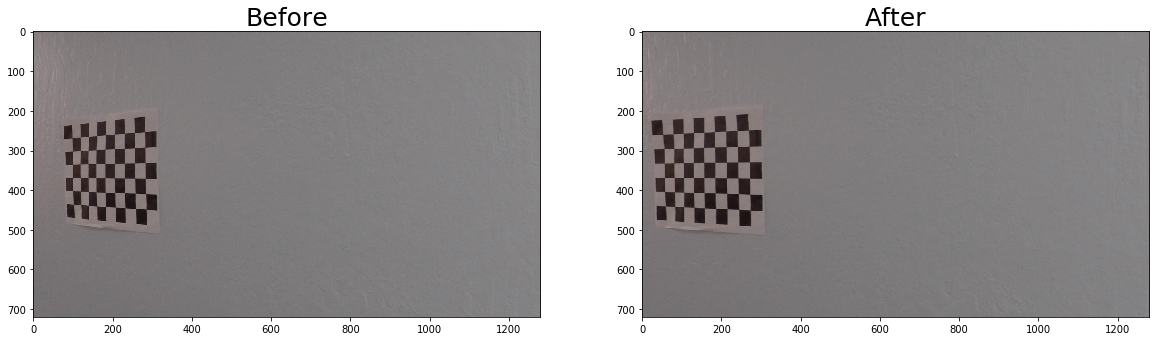

In [5]:
'''
Read a random image
'''
import random
distort_image = cv2.imread(random.choice(list_of_images[:5]))

undistorted_image_chessboard = undistorted_image(distort_image)
'''
save undistorted_image
'''
undistorted_image_path = './output_images/undistorted_image.jpg'
cv2.imwrite(undistorted_image_path, undistorted_image_chessboard)

'''
Display distort_image and undistorted_image
'''
display_image(distort_image, None, undistorted_image_chessboard, None)

# Pipeline(test images)

### Distortion corrected on road image
### Goal
- [X] Distortion corrected on road line
- [X] Save undistorted image

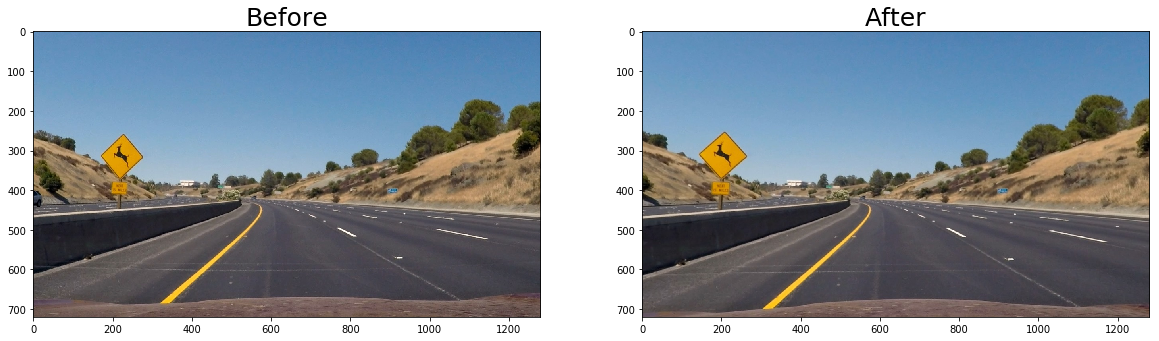

In [6]:
'''
Read a random image
'''
import random

list_of_road_images =  glob.glob("test_images/test*.jpg")
assert len(list_of_images) > 0, "list_of_road_images should not be empty, " + str(len(list_of_road_images))

distort_image = cv2.imread(random.choice(list_of_road_images))

undistorted_image_road = undistorted_image(distort_image)
'''
save undistorted_image_road
'''
undistorted_image_path = './output_images/undistorted_image_road.jpg'
cv2.imwrite(undistorted_image_path, undistorted_image_road)

'''
Display distort_image and undistorted_image
'''
display_image(cv2.cvtColor(distort_image, cv2.COLOR_BGR2RGB), None, 
              cv2.cvtColor(undistorted_image_road, cv2.COLOR_BGR2RGB), None)

# Color transformation
    Calculate color transforms, gradients and other methods to create a thresholded binary image

### Goal
- [X] Calculate directional gradient
- [X] Calculate gradient magnitude
- [X] Calculate gradient direction
- [X] Calculate color threshold
- [X] Combine all threshold

## Calculate directional gradient
    Apply the Sobel x and y operators to image.
    
### Goal
- [X] Convert to gray
- [X] Apply sobel 
- [X] Calculate absolute value
- [X] Calculate threshold

In [7]:
def absolute_sobel_threshold(undistorted_image, orient='x', threshold_minimum=0, threshold_maximum=255):
    '''
    Convert to grayscale
    '''
    gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
    
    '''
    Apply sobel and calculate absolute value
    '''
    absolute_sobel = np.absolute(cv2.Sobel(gray_image, cv2.CV_64F,
                                           1 if orient == 'x' else 0,
                                           0 if orient == 'x' else 1,
                                           5))
    
    '''
    Rescale back to 8 bit
    '''
    resized_sobel = np.uint8(255 * absolute_sobel/np.max(absolute_sobel))
    
    '''
    Make a copy
    '''
    threshold = np.zeros_like(resized_sobel)
    
    '''
    Apply thresholds max and min
    '''
    threshold[(resized_sobel >= threshold_minimum) & (resized_sobel <= threshold_maximum)] = 1
    
    # return threshold image
    return threshold

### [TEST] - absolute_sobel_threshold

In [8]:
'''
Copy a undistorted_image_road
'''
directional_gradient_image = np.copy(undistorted_image_road)

#### [Test - Sobel X]

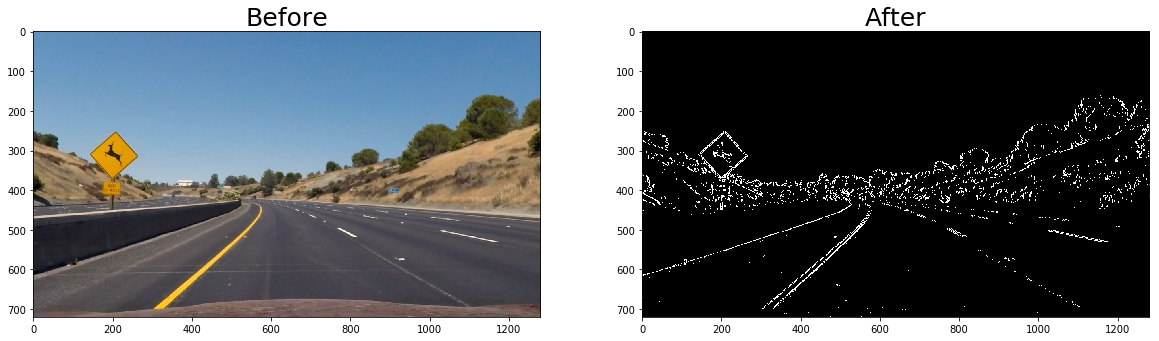

In [9]:
# sobel x test
absolut_sobel_threshold_x_outut = absolute_sobel_threshold(directional_gradient_image, # image
                                                          orient='x',                  # orient
                                                          threshold_minimum=30,        # min 
                                                          threshold_maximum=100)       # max

'''
Display directional_gradient_image and absolut_sobel_threshold_x_outut
'''
display_image(cv2.cvtColor(directional_gradient_image, cv2.COLOR_BGR2RGB), None, 
              absolut_sobel_threshold_x_outut, "gray")

#### [Test - Sobel Y]

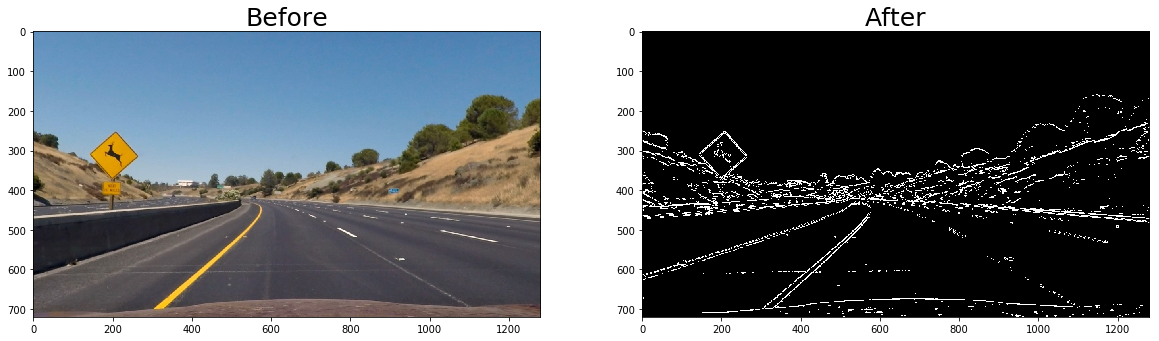

In [10]:
# sobel y test
absolut_sobel_threshold_x_outut = absolute_sobel_threshold(directional_gradient_image, # image
                                                          orient='y',                  # orient
                                                          threshold_minimum=30,        # min 
                                                          threshold_maximum=100)       # max

'''
Display directional_gradient_image and absolut_sobel_threshold_x_outut
'''
display_image(cv2.cvtColor(directional_gradient_image, cv2.COLOR_BGR2RGB), None, 
              absolut_sobel_threshold_x_outut, "gray")

## Calculate gradient magnitude
    calculate the magnitude of the gradient and apply threshold

### Goal
- [X] Convert to grayscale
- [X] Apply Sobel
- [X] Calculate gradient magnitude
- [X] Apply threshold

In [11]:
def gradient_magnitude_threshold(undistorted_image, sobel_kernel=3, threshold_minimum=0, threshold_maximum=255):
    '''
    Convert to grayscale
    '''
    gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY)
    
    '''
    Apply sobel for x and y
    '''
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    '''
    Calculate gradient magnitude and rescale to 8 bit
    '''
    gradient_magnitude = np.sqrt((sobel_x**2) + (sobel_y**2))
    scale_factor = np.max(gradient_magnitude)/255
    gradient_magnitude = (gradient_magnitude/scale_factor).astype(np.uint8)
    
    '''
    Make a copy
    '''
    threshold = np.zeros_like(gradient_magnitude)
    
    '''
    Apply threshold max and min
    '''
    threshold[(gradient_magnitude >= threshold_minimum) & (gradient_magnitude <= threshold_maximum)] = 1
    
    # return
    return threshold

### [TEST] - gradient_magnitude_threshold

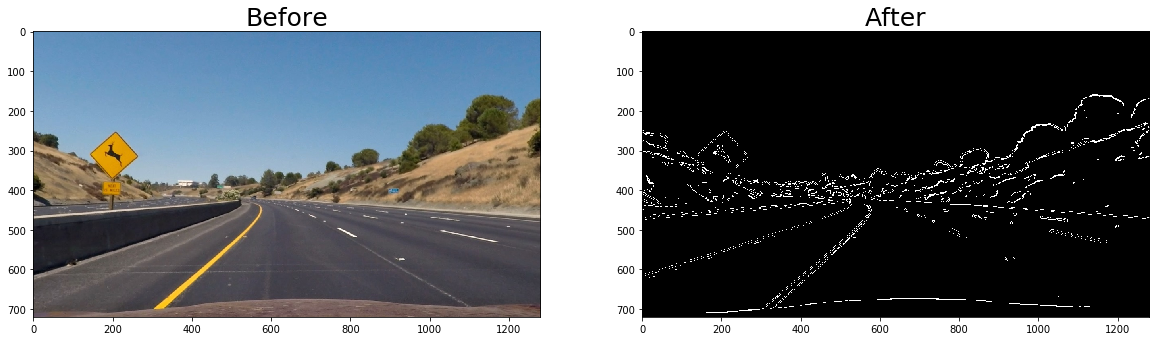

In [12]:
'''
Copy a undistorted_image_road
'''
gradient_magnitude_image = np.copy(undistorted_image_road)

# test gradient_magnitude_threshold
gradient_magnitude_threshold_output = gradient_magnitude_threshold(gradient_magnitude_image,
                                                                  sobel_kernel=15,
                                                                  threshold_minimum=70,
                                                                  threshold_maximum=100)

'''
Display gradient_magnitude_image and gradient_magnitude_threshold_output
'''
display_image(cv2.cvtColor(gradient_magnitude_image, cv2.COLOR_BGR2RGB), None,
             gradient_magnitude_threshold_output, "gray")

## Calculate gradient direction
    calculate the direction of the gradient and apply threshold

### Goal
- [X] Convert to grayscale
- [X] Apply Sobel
- [X] Calculate gradient direction
- [X] Apply threshold

In [13]:
def gradient_direction_threshold(undistorted_image, sobel_kernel=3, threshold_minimum=0, threshold_maximum=255):
    '''
    Convert to grayscale
    '''
    gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY)
    
    '''
    Apply sobel in x and y
    '''
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    '''
    Calculate gradient direction
    '''
    absolute_gradient_direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    '''
    Apply threshold max and min
    '''
    threshold = np.zeros_like(absolute_gradient_direction)
    threshold[(absolute_gradient_direction >= threshold_minimum) & (absolute_gradient_direction <= threshold_maximum)] = 1
    
    # return
    return threshold

### [TEST] - gradient_direction_threshold

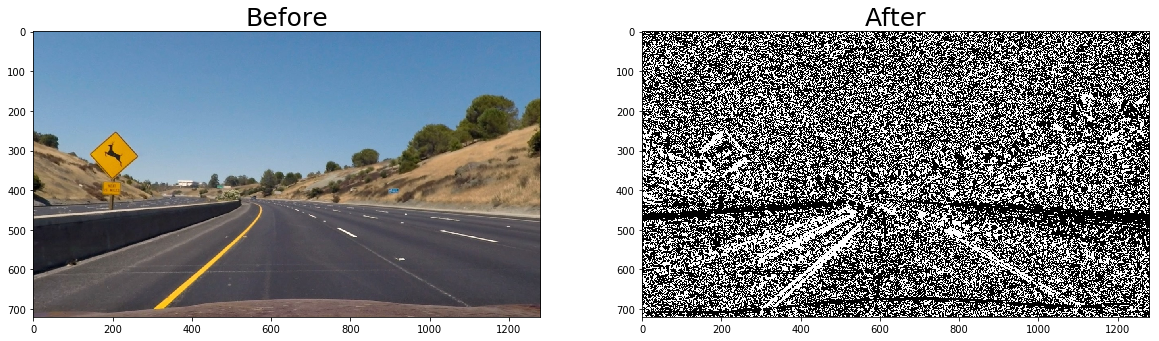

In [14]:
'''
Copy a undistorted_image_road
'''
gradient_direction_image = np.copy(undistorted_image_road)

#test gradient_direction_threshold
gradient_direction_threshold_output = gradient_direction_threshold(gradient_direction_image,
                                                                  sobel_kernel=15,
                                                                  threshold_minimum=0.7,
                                                                  threshold_maximum=1.3)

'''
Display gradient_direction_image and gradient_direction_threshold_output
'''
display_image(cv2.cvtColor(gradient_direction_image, cv2.COLOR_BGR2RGB), None,
             gradient_direction_threshold_output, "gray")

## Calculate color threshold
    calculate the HSL of the image
    
### Goal
- [X] Convert to HSL
- [X] Select a color channel
- [X] Apply threshold

In [15]:
def color_threshold(undistorted_image, channel='S', threshold_minimum=0, threshold_maximum=255):
    '''
    Convert to HLS
    '''
    HLS_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
    
    '''
    Select channel 
    '''
    color_channel = None
    
    if channel == 'H':
        color_channel = HLS_image[:,:,0] # H-Channel
    elif channel == 'L':
        color_channel = HLS_image[:,:,1] # L-Channel
    elif channel == 'S':
        color_channel = HLS_image[:,:,2] # S-Channel
    
    '''
    Apply threshold max and min
    '''
    threshold = np.zeros_like(color_channel)
    threshold[(color_channel >= threshold_minimum) & (color_channel <= threshold_maximum)] = 1
    
    # return
    return threshold

## [TEST] - color threshold

In [16]:
'''
Copy a undistorted_image_road
'''
color_threshold_image = np.copy(undistorted_image_road)

#### [TEST - H Channel color]

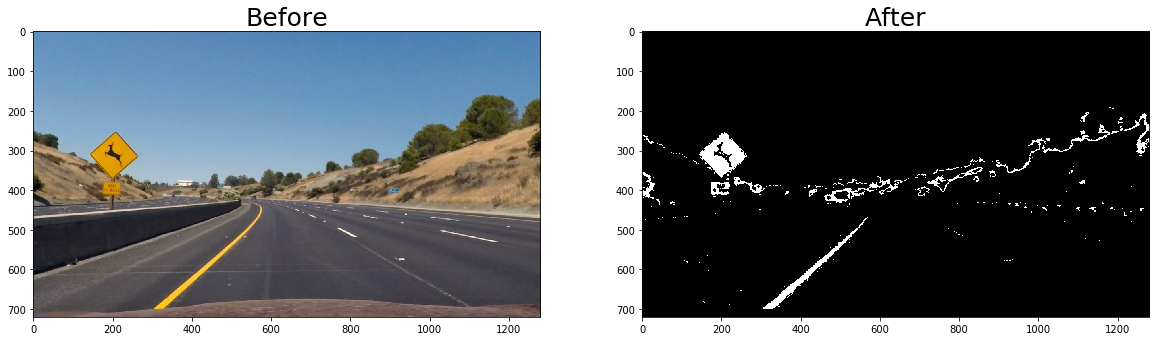

In [17]:
# test color threshold
H_color_channel = color_threshold(color_threshold_image,
                                 channel='H',
                                 threshold_minimum=97,
                                 threshold_maximum=100)

'''
Display color_threshold_image and H_color_channel
'''
display_image(cv2.cvtColor(color_threshold_image, cv2.COLOR_BGR2RGB), None,
             H_color_channel, "gray")

#### [TEST - L Channel color]

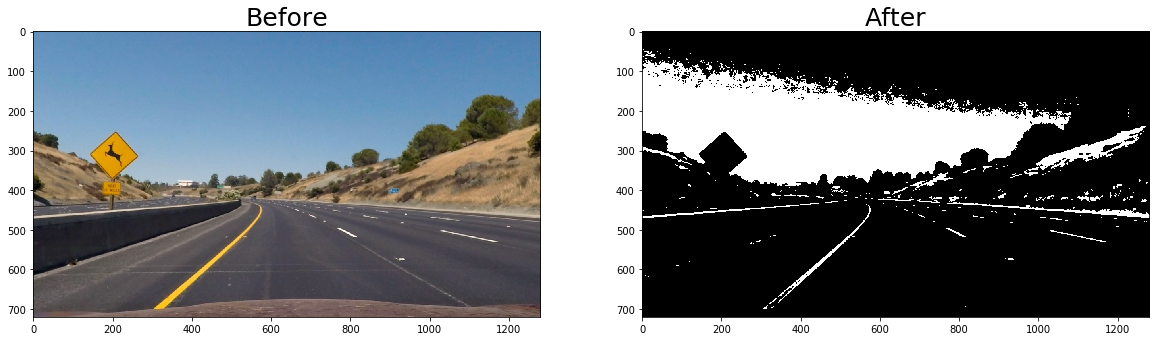

In [18]:
# test color threshold
L_color_channel = color_threshold(color_threshold_image,
                                 channel='L',
                                 threshold_minimum=150,
                                 threshold_maximum=255)

'''
Display color_threshold_image and L_color_channel
'''
display_image(cv2.cvtColor(color_threshold_image, cv2.COLOR_BGR2RGB), None,
             L_color_channel, "gray")

#### [TEST - S Channel color]

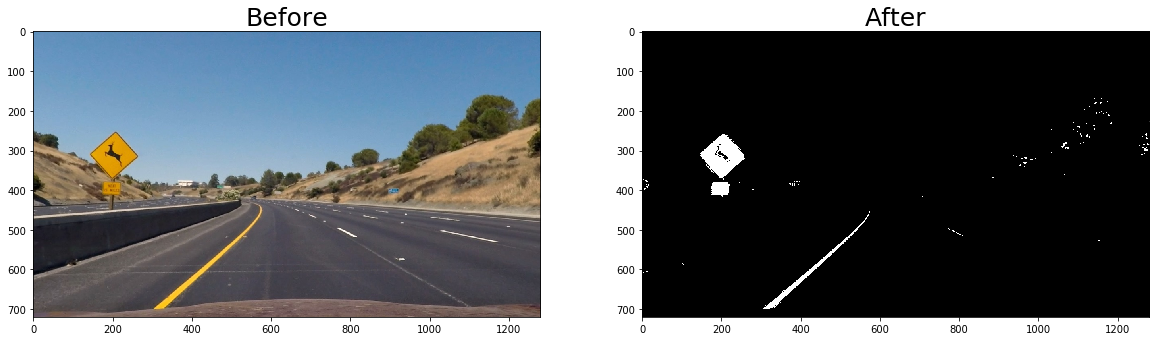

In [19]:
# test color threshold
S_color_channel = color_threshold(color_threshold_image,
                                 channel='S',
                                 threshold_minimum=170,
                                 threshold_maximum=255)

'''
Display color_threshold_image and L_color_channel
'''
display_image(cv2.cvtColor(color_threshold_image, cv2.COLOR_BGR2RGB), None,
             S_color_channel, "gray")

## Combine all threshold
    combine all the calculated threshold
    
### Goal
- [X] Make a copy
- [X] Combine all threshold

In [20]:
def combine_all_threshold(sobel_x_threshold_, 
                         sobel_y_threshold_,
                         gradient_magnitude_threshold_,
                         gradient_direction_threshold_,
                         color_threshold_,
                         ksize=15):
    '''
    Combine all threshold
    
    threshold = sobel_x + sobel_y + grad_mag + grad_dir + col_threshold
    '''
    combined_threshold = np.zeros_like(gradient_direction_threshold_)
    combined_threshold[((sobel_x_threshold_ == 1) & (sobel_y_threshold_ == 1)) | 
                      ((gradient_magnitude_threshold_ == 1) & (gradient_direction_threshold_ == 1)) |
                      (color_threshold_ == 1)] = 1
    
    # return
    return combined_threshold

### [TEST] Combine all the treshold

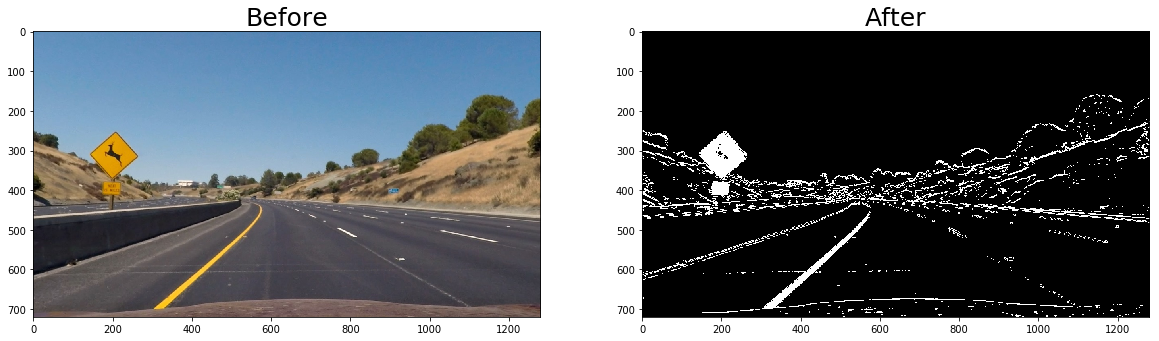

In [21]:
# combine all
combined_threshold = combine_all_threshold(absolut_sobel_threshold_x_outut,
                                           absolut_sobel_threshold_x_outut,
                                           gradient_magnitude_threshold_output,
                                           gradient_direction_threshold_output,
                                           S_color_channel,
                                           ksize=15)

'''
Display final threshold image
'''
display_image(cv2.cvtColor(color_threshold_image, cv2.COLOR_BGR2RGB), None,
             combined_threshold, "gray")